In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Let's start by pulling in the .csv we made in our GPI religion pull
df = pd.read_csv('gpi_by_rel.csv', index_col=0)

print(df.head(10))

             2019 rank  2019 score  Christians  Muslims  Unaffiliated  Hindus  \
Afghanistan        158       3.300         0.1     99.7           0.1     0.1   
Albania             51       1.821        18.0     80.3           1.4     0.1   
Algeria            111       2.219         0.2     97.9           1.8     0.1   
Angola              77       2.012        90.5      0.2           5.1     0.1   
Argentina           75       1.989        85.2      1.0          12.2     0.1   
Armenia            118       2.294        98.5      0.1           1.3     0.1   
Australia           13       1.419        67.3      2.4          24.2     1.4   
Austria              4       1.291        80.4      5.4          13.5     0.1   
Azerbaijan         130       2.425         3.0     96.9           0.1     0.1   
Bahrain            124       2.357        14.5     70.3           1.9     9.8   

             Buddhists  Folk Religions  Other  Jews    All  
Afghanistan        0.1             0.1    0.1  

In [40]:
#let's sort it by their rank and see the top ten and bottom ten
dfa = df.sort_values(df.columns[0])
print(dfa.head(10))
print(dfa.tail(10))

             2019 rank  2019 score  Christians  Muslims  Unaffiliated  Hindus  \
Iceland              1       1.072        95.0      0.2           3.5     0.3   
New Zealand          2       1.221        57.0      1.2          36.6     2.1   
Portugal             3       1.274        91.9      0.3           7.5     0.1   
Austria              4       1.291        80.4      5.4          13.5     0.1   
Denmark              5       1.316        83.5      4.1          11.8     0.4   
Canada               6       1.327        69.0      2.1          23.7     1.4   
Singapore            7       1.347        18.2     14.3          16.4     5.2   
Slovenia             8       1.355        78.4      3.6          18.0     0.1   
Japan                9       1.369         1.6      0.2          57.0     0.1   
Switzerland         10       1.375        72.7      4.9          20.9     0.5   

             Buddhists  Folk Religions  Other  Jews    All  
Iceland            0.4             0.5    0.2  

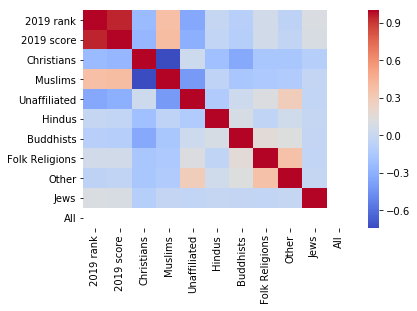

In [41]:
# The sorting showed that the original email that caused me to investigate this data was lying.  Several of the countries
# Listed in the top ten or bottoms ten did not match this list.  The email authors had altered the data to try to make
# their argument stronger.

# We are primarily looking for correlation between score and religion, so lets plot a heatmap of correlation matrix
# and do some EDA
corrmat = df.corr()
sns.heatmap(data=corrmat, cmap='coolwarm')
plt.show()

In [42]:
# In fact, according to the correlation matrix, Islam is the only faith that seems to have a positive correlation.
# (In this case, a positive value means a country is less safe remember, so you don't want a positive correlation.)

# to make later analysis easier, lets make a list with just the religions names
religions = df.columns[2:10]
print(religions)

Index(['Christians', 'Muslims', 'Unaffiliated', 'Hindus', 'Buddhists',
       'Folk Religions', 'Other', 'Jews'],
      dtype='object')


In [43]:
#Let's define a function to give us the pearson correlation coeficient

def pearson_r(x, y):
    """Compute Pearson correlation coefficient between two arrays."""
    # Compute correlation matrix: corr_mat
    corr_mat = np.corrcoef(x, y)

    # Return entry [0,1]
    return corr_mat[0,1]

In [44]:
#Let's find the pearson correlation for religions and GPI
r_list = []

for rel in religions:
    r = pearson_r(df['2019 score'], df[rel])
    print('pearson coeficient of {} to GPI score:'.format(rel), r)
    r_list.append(r)

#and store it in a dictionary in case we want it later    
religion_pearsons = dict(zip(religions, r_list))

pearson coeficient of Christians to GPI score: -0.25970772274771947
pearson coeficient of Muslims to GPI score: 0.3936161390085939
pearson coeficient of Unaffiliated to GPI score: -0.3026166759787703
pearson coeficient of Hindus to GPI score: -0.02919532095869543
pearson coeficient of Buddhists to GPI score: -0.09969837225403802
pearson coeficient of Folk Religions to GPI score: 0.05447399995422289
pearson coeficient of Other to GPI score: -0.0392402944362994
pearson coeficient of Jews to GPI score: 0.09525459986131775


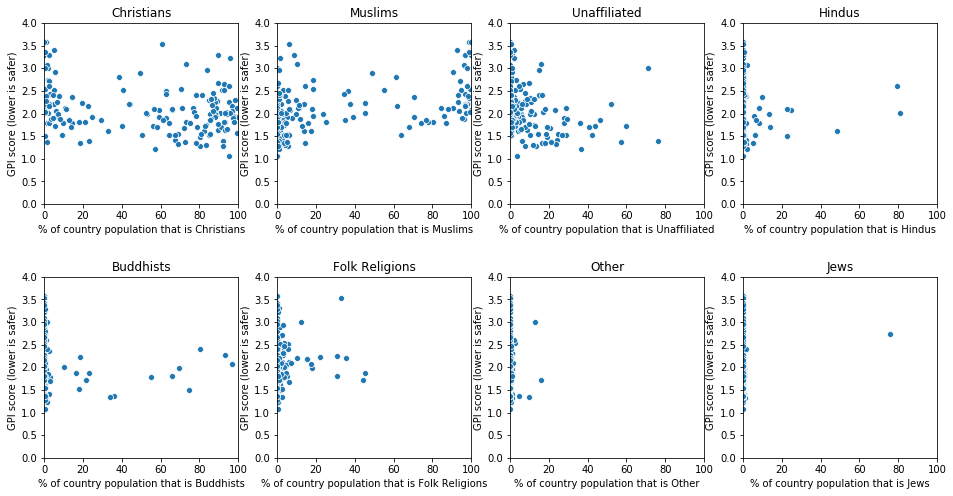

In [45]:
#so far most of those have very week pearson coefficients. Christianity, Islam, and Unaffiliated are the only ones
#to have an absolute value over 0.1 even.

#Let's make some very basic scatterplots of each religion and see how things look to the naked eye.

rel_range = np.arange(2, 10)
fig = plt.figure(figsize=(16,8))
plt.subplots_adjust(hspace=0.4)

for i in rel_range:
    ax = plt.subplot(2, 4, (i-1))
    sns.scatterplot(data=df, x=df.columns[i], y='2019 score')
    plt.xlabel('% of country population that is {}'.format(df.columns[i]))
    plt.ylabel('GPI score (lower is safer)')
    plt.title(df.columns[i])
    plt.xlim(0,100)
    plt.ylim(0, 4)
                     
plt.show()

In [46]:
#initialize an empty p-val list
p_vals = []
#For loop over each religion we want to check
for rel in religions:
    # Initialize permutation replicates: perm_replicates
    perm_replicates = np.empty(10000)

    # Draw replicates
    for i in range(10000):
        # Permute measurments: rel_permuted
        rel_permuted = np.random.permutation(df[rel])

        # Compute Pearson correlation
        perm_replicates[i] = pearson_r(rel_permuted, df['2019 score'])

    # Compute p-value: p
    # we need to consider abs because our coefficient can be positive or negative
    p = np.sum(abs(perm_replicates) >= abs(religion_pearsons[rel])) / len(perm_replicates)
    p_vals.append(p)
religion_p_vals = dict(zip(religions, p_vals))
print('pearson correlations:', religion_pearsons)
print('p-values:', religion_p_vals)

pearson correlations: {'Christians': -0.25970772274771947, 'Muslims': 0.3936161390085939, 'Unaffiliated': -0.3026166759787703, 'Hindus': -0.02919532095869543, 'Buddhists': -0.09969837225403802, 'Folk Religions': 0.05447399995422289, 'Other': -0.0392402944362994, 'Jews': 0.09525459986131775}
p-values: {'Christians': 0.0009, 'Muslims': 0.0, 'Unaffiliated': 0.0, 'Hindus': 0.7101, 'Buddhists': 0.1988, 'Folk Religions': 0.4893, 'Other': 0.6142, 'Jews': 0.1899}


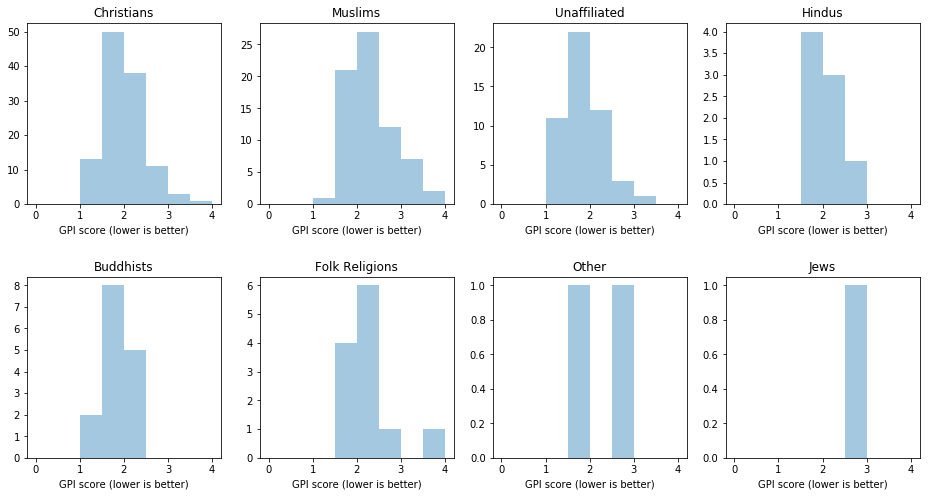

In [47]:
#p-value of 0 with 10000 bootstrap permutations means that our p-value is less than 0.0001
#that is highly statistically relevant, though the pearson coeficient of roughly 0.4 is not that strong.
#this does imply that there is some correlation between Islam and GPI score, but remember, it doesn't mean causality!
#It also appears as though no religion and christianity have a slight correlation to safer GPI scores.

#One thing we saw in the scatterplots is that most countries have one or two large religeous populations and then a lot
#of small (less than 5% populations) populations for the other religions.  It's rare to see a country with multiple religions
#in meaningful sizes of the population.  Small populations of a religion will likely have negligible effect on culture and
#policy.  So let's do those analysis again but without small populations.

#We'll start this round with some simple histograms to see how they look without low pops
rel_range = np.arange(2, 10)
fig = plt.figure(figsize=(16,8))
plt.subplots_adjust(hspace=0.4)

for i in rel_range:
    ax = plt.subplot(2, 4, (i-1))
    sns.distplot(df['2019 score'][df[df.columns[i]] >= 10], kde=False, bins=[0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4])
    plt.title(df.columns[i])
    plt.xlabel('GPI score (lower is better)')

                     
plt.show()

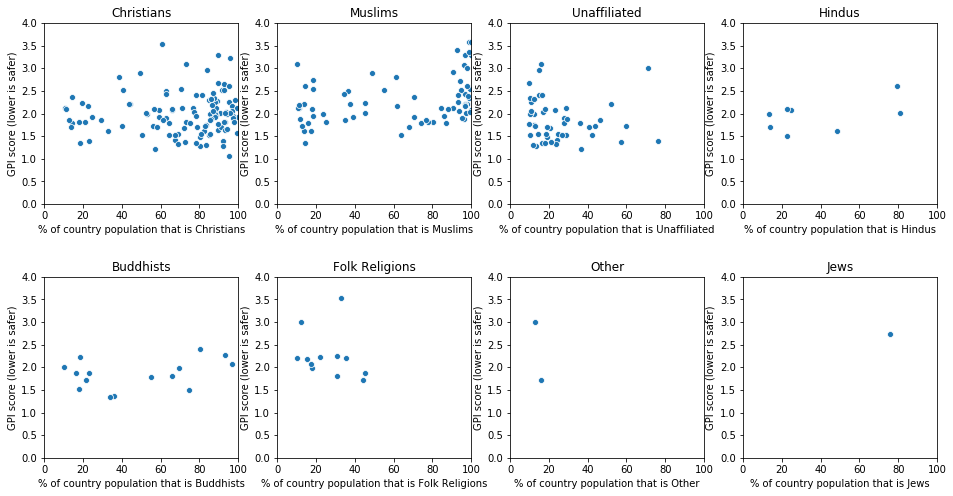

In [48]:
#next, lets examine scatterplots against with the 10% population requirement
rel_range = np.arange(2, 10)
fig = plt.figure(figsize=(16,8))
plt.subplots_adjust(hspace=0.4)

i=1
for rel in religions:
    per10 = df[df[rel] >= 10]
    ax = plt.subplot(2, 4, (i))
    sns.scatterplot(data=per10, x=rel, y='2019 score')
    plt.xlabel('% of country population that is {}'.format(rel))
    plt.ylabel('GPI score (lower is safer)')
    plt.title(rel)
    plt.xlim(0,100)
    plt.ylim(0, 4)
    i += 1
                     
plt.show()

In [49]:
#None of these have a very clear visual trend.  Let's check pearsons and p_values again like before.
#this time however, "other" and "Judaism" don't have enought data points to be used, so we will drop them.

newreligions = religions[0:6]

r_list10 = []

for rel in newreligions:
    per10 = df[df[rel] >= 10]
    r = pearson_r(per10['2019 score'], per10[rel])
    #print('pearson coeficient of {} to GPI score:'.format(rel), r)
    r_list10.append(r)

#and store it in a dictionary in case we want it later    
religion_pearsons10 = dict(zip(newreligions, r_list10))

#initialize an empty p-val list
p_vals10 = []
#For loop over each religion we want to check
for rel in newreligions:
    per10 = df[df[rel] >= 10]
    # Initialize permutation replicates: perm_replicates
    perm_replicates = np.empty(10000)

    # Draw replicates
    for i in range(10000):
        # Permute measurments: rel_permuted
        rel_permuted = np.random.permutation(per10[rel])

        # Compute Pearson correlation
        perm_replicates[i] = pearson_r(rel_permuted, per10['2019 score'])

    # Compute p-value: p
    # remember the abs again
    p = np.sum(abs(perm_replicates) >= abs(religion_pearsons10[rel])) / len(perm_replicates)
    p_vals10.append(p)
religion_p_vals10 = dict(zip(newreligions, p_vals10))
print('pearson correlations:', religion_pearsons10)
print('p-values:', religion_p_vals10)

pearson correlations: {'Christians': 0.05284424485008659, 'Muslims': 0.3346932342180262, 'Unaffiliated': -0.0944669051478771, 'Hindus': 0.49997339115817324, 'Buddhists': 0.35046890752233006, 'Folk Religions': -0.2276394761842183}
p-values: {'Christians': 0.5852, 'Muslims': 0.0048, 'Unaffiliated': 0.5239, 'Hindus': 0.2087, 'Buddhists': 0.197, 'Folk Religions': 0.4925}


(0, 4)

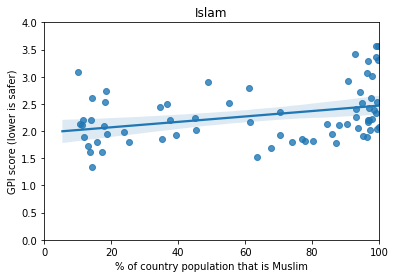

In [50]:
#Christianity and Unaffiliated no longer show much of any correlation.  In fact, Christianity even went from a negative value
#to a barely positive one.  But the p-values on all of these correlations are above relevance except for Islam again.  So none
#of the others really matter.

# let's fit a line to the only religion that showed relevant results in both checks and see how it looks.

fig = plt.figure(figsize=(6,4))

sns.regplot(data=df[df['Muslims'] >= 10], x='Muslims', y='2019 score')
plt.xlabel('% of country population that is Muslim')
plt.ylabel('GPI score (lower is safer)')
plt.title('Islam')
plt.xlim(0,100)
plt.ylim(0, 4)

In [54]:
# In the end I have to admit that there does seem to be a connection between percent Muslim population and GPI score.
# In no way does this prove causation, but it does warrant examining if there are perhaps biases in the metrics
# or some other possible followups (if I had the ability!).  Maybe the GPI is biased against Muslim cultures since
# the organization originated in a traditionally christian country.  Maybe western countries are actually to blame
# for unrest and fighting in Muslim countries due to imperialist actions.  There could be a million complex and indirect
# explanations for why, but this analysis does show that GPI scores tend to go up very slightly with increased
# Muslim populations.  This is what I had hoped to disprove to my father setting out, but I have to admit, I cannot.

# I did decide to check one more factor on my own initiative.  Did having a homogenized culture of religion have any correlation
# with GPI score, regardless of the religion(s) in question?

# create two new columns: 
# homogenized, which measures the largest single population
# and relnum, which measures how many religions exist over 10% pop
df['homogenized'] = df[religions].max(axis=1)
dft = df[religions] >= 10
df['relnum'] = dft.sum(axis=1)
print(df.head(10))

             2019 rank  2019 score  Christians  Muslims  Unaffiliated  Hindus  \
Afghanistan        158       3.300         0.1     99.7           0.1     0.1   
Albania             51       1.821        18.0     80.3           1.4     0.1   
Algeria            111       2.219         0.2     97.9           1.8     0.1   
Angola              77       2.012        90.5      0.2           5.1     0.1   
Argentina           75       1.989        85.2      1.0          12.2     0.1   
Armenia            118       2.294        98.5      0.1           1.3     0.1   
Australia           13       1.419        67.3      2.4          24.2     1.4   
Austria              4       1.291        80.4      5.4          13.5     0.1   
Azerbaijan         130       2.425         3.0     96.9           0.1     0.1   
Bahrain            124       2.357        14.5     70.3           1.9     9.8   

             Buddhists  Folk Religions  Other  Jews    All  homogenized  \
Afghanistan        0.1           

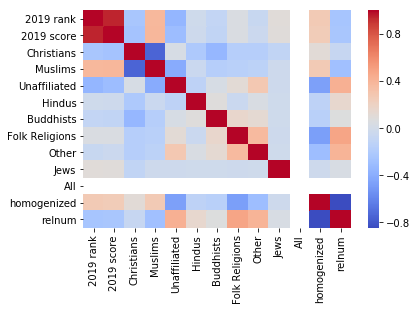

pearson coeficient of homogenized to GPI score: 0.255240232998589
pearson coeficient of number of religions to GPI score: -0.23505932919413286


In [57]:
# Let's run correlation matrix and pearson again
corrmat = df.corr()
sns.heatmap(data=corrmat, cmap='coolwarm')
plt.show()

homogenized_r = pearson_r(df['2019 score'], df['homogenized'])
print('pearson coeficient of homogenized to GPI score:', homogenized_r)

relnum_r = pearson_r(df['2019 score'], df['relnum'])
print('pearson coeficient of number of religions to GPI score:', relnum_r)

In [58]:
# Interesting, it seems the more religiously homogenized a country is, the worse it's GPI score.
# Let's check the p-values to see if it's random

# Draw replicates
for i in range(10000):
    # Permute measurments: rel_permuted
    rel_permuted = np.random.permutation(df['homogenized'])

    # Compute Pearson correlation
    perm_replicates[i] = pearson_r(rel_permuted, df['2019 score'])

# Compute p-value: p
# we need to consider abs because our coefficient can be positive or negative
homogenized_p = np.sum(abs(perm_replicates) >= abs(homogenized_r)) / len(perm_replicates)

# Draw replicates
for i in range(10000):
    # Permute measurments: rel_permuted
    rel_permuted = np.random.permutation(df['relnum'])

    # Compute Pearson correlation
    perm_replicates[i] = pearson_r(rel_permuted, df['2019 score'])

# Compute p-value: p
# we need to consider abs because our coefficient can be positive or negative
relnum_p = np.sum(abs(perm_replicates) >= abs(relnum_r)) / len(perm_replicates)

print('p-value of homogenized to GPI score:', homogenized_p)
print('p-value of number of religions to GPI score:', relnum_p)

p-value of homogenized to GPI score: 0.002
p-value of number of religions to GPI score: 0.002


In [65]:
# Both prove to be statistically relevant and have pearson correlations similar to the strongest correlation found for
# any single type of religion.